In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* CAD/JPY exchange rate returns. 

In [2]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [3]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Data Preparation

### Returns

In [5]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
cad_jpy_df['Returns'] = cad_jpy_df['Price'].pct_change()*100
cad_jpy_df.replace([np.inf, -np.inf], np.nan,inplace=True)
cad_jpy_df.dropna(inplace=True)
cad_jpy_df.tail()

,Price,Open,High,Low,Returns
Date,,,,,
2020-05-29,78.29,78.21,78.41,77.75,0.076697
2020-06-01,79.27,78.21,79.36,78.04,1.251756
2020-06-02,80.40,79.26,80.56,79.15,1.425508
2020-06-03,80.70,80.40,80.82,79.96,0.373134
2020-06-04,80.71,80.80,80.89,80.51,0.012392


### Lagged Returns 

In [7]:
# Create a lagged return using the shift function
cad_jpy_df['Lagged_Return'] = cad_jpy_df.Returns.shift()
cad_jpy_df = cad_jpy_df.dropna()
cad_jpy_df.tail()

,Price,Open,High,Low,Returns,Lagged_Return
Date,,,,,,
2020-05-29,78.29,78.21,78.41,77.75,0.076697,-0.114913
2020-06-01,79.27,78.21,79.36,78.04,1.251756,0.076697
2020-06-02,80.40,79.26,80.56,79.15,1.425508,1.251756
2020-06-03,80.70,80.40,80.82,79.96,0.373134,1.425508
2020-06-04,80.71,80.80,80.89,80.51,0.012392,0.373134


### Train Test Split

In [9]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = cad_jpy_df[:'2017']
test = cad_jpy_df['2018':]

In [10]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train['Lagged_Return'].to_frame()
y_train = train['Returns']
X_test = test['Lagged_Return'].to_frame()
y_test = test['Returns']

In [13]:
# Preview the X_train data
X_train.head()

,Lagged_Return
Date,
1990-01-08,0.874777
1990-01-09,-0.216798
1990-01-10,0.667901
1990-01-11,0.567546
1990-01-12,0.031794


# Linear Regression Model

In [14]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression
model = LinearRegression()
# Fit a SKLearn linear regression using  just the training set (X_train, Y_train):
model.fit(X_train,y_train)

LinearRegression()

# Make predictions using the Testing Data

**Note:** We want to evaluate the model using data that it has never seen before, in this case: `X_test`.

In [15]:
# Make a prediction of "y" values using just the test dataset
y = y_test.values.reshape(-1,1)
predictions = model.predict(X_test)

In [16]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted_Return"] = predictions
Results.head()

,Returns,Predicted_Return
Date,,
2018-01-01,0.245591,0.005525
2018-01-02,-0.055679,-0.007229
2018-01-03,0.011142,0.000430
2018-01-04,0.601604,-0.001269
2018-01-05,0.919158,-0.016280


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000149320CFDF0>,
      dtype=object)

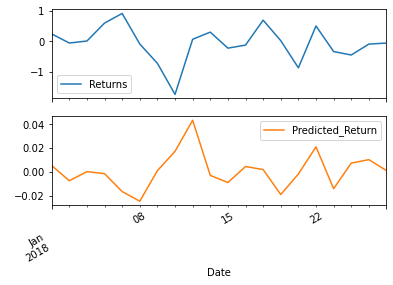

In [17]:
# Plot the first 20 predictions vs the true values
Results[:20].plot(subplots=True)

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (`X_test` and `y_test`)

In [20]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
# (Hint: use the dataframe from above)
mse = mean_squared_error(
    Results["Returns"],
    Results["Predicted_Return"]
)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
out_of_sample_rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {out_of_sample_rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 0.6445820942663303


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [21]:
# Construct a dataframe using just the "y" training data:
sample_results = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
sample_results["In-sample Predictions"] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
sample_mse = mean_squared_error(
    sample_results["Returns"],
    sample_results["In-sample Predictions"]
)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
sample_rmse = np.sqrt(sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE): {sample_rmse}")

In-sample Root Mean Squared Error (RMSE): 0.8418722775348019


# Conclusions

**Question:** Does this model perform better or worse on out-of-sample data as compared to in-sample data?

**Answer:** This model perform worse on out-of-sample data as compared to in-sample data, which is not a reliable model. Empirical evidence based on out-of-sample forecast performance is generally considered more trustworthy than evidence based on in-sample performance.